In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pystan
from sklearn import datasets, decomposition 
from py_stan_code.helper_functions import StanModel_cache

%matplotlib inline 

In [3]:
def stan_model(file):
    with open(file) as f:
        stan_code = f.read()
    return StanModel_cache(model_code=stan_code)
    
    
file1 = "py_stan_code/ppca_house.stan"
file2 = "py_stan_code/ppca.stan"

ppca_house_model = stan_model(file1)
ppca_model = stan_model(file2)

Using cached StanModel
Using cached StanModel


In [4]:
def run_calc(model, Y, N, D, Q, chains=2, iterations=1000):
    data_dict = {'N':N, 'D':D, 'Q':Q, 'Y':Y}
    samples = model.sampling(data_dict, chains=chains, iter=iterations)
    return samples


def sign_convention(U):
    """
    sign convention
    """
    return np.array( [-U[:,q] if U[0,q] < 0 else U[:,q] for q in range(U.shape[1])] ).T

<h1>Breast Cancer Dataset</h1>

<p>Because of the ordered eigenvalue vector in stan, in some rare cases there might be some convergence issues (due to random initialization). By looking at the loglikelihood values, those chains can be excluded afterwards.</p>

In [5]:
Q_fit = 2

Y =  datasets.load_breast_cancer()["data"]
Y = (Y - Y.mean(axis=0))/Y.std(axis=0)
N,D = Y.shape

In [6]:
%time ppca = run_calc(ppca_model, Y, N, D, Q_fit)
%time ppca_house = run_calc(ppca_house_model, Y, N, D, Q_fit)

CPU times: user 2.67 s, sys: 1.59 s, total: 4.26 s
Wall time: 27min 24s
CPU times: user 1.77 s, sys: 1.35 s, total: 3.12 s
Wall time: 19min 49s


In [7]:
# PCA solution
pca = decomposition.PCA(n_components=Q_fit)
pca.fit(Y)
U_pca = pca.components_.T   
U_pca = sign_convention(U_pca)
sigma_pca = np.sqrt(pca.explained_variance_)
W_pca = np.dot(U_pca,np.diag(sigma_pca))

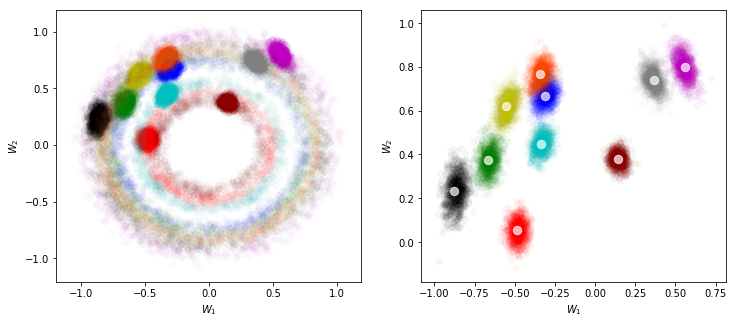

In [8]:
W_ppca = ppca.extract(['W'])['W']
W_house = ppca_house.extract(['W_n'])['W_n']


c = 5*['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orangered', 'grey', 'darkred', 
     'lawngreen', 'indigo', 'deeppink', 'deepskyblue', 'goldenrod']
def plt_info(ax, x=None, y=None, legend=None, title=None):
    if x is not None: ax.set_xlabel(x)
    if y is not None: ax.set_ylabel(y)
    if legend is not None: ax.legend()
    if title is not None: ax.set_title(title)


#show N_show random columns of W 
D_show = 10
ds = np.arange(0, W_ppca.shape[1])
np.random.shuffle(ds)
ds = ds[:D_show]


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,2,1)
for i,d in enumerate(ds):
    ax.scatter(W_ppca[:,d,0], W_ppca[:,d,1], alpha=0.02, c=c[i], rasterized=True)
    ax.scatter(W_house[:,d,0], W_house[:,d,1], alpha=0.05, c=c[i], rasterized=True)
plt_info(ax, '$W_1$', '$W_2$')

ax = fig.add_subplot(1,2,2)
for i,d in enumerate(ds):
    ax.scatter(W_house[:,d,0], W_house[:,d,1], alpha=0.03, c=c[i], rasterized=True)
plt_info(ax, '$W_1$', '$W_2$')

ax.scatter(W_pca[ds,1], W_pca[ds,0], marker='o', s=70,  c='w', alpha=0.7)

plt.show()